# Lyapunov exponents of the Teichmüller flow
## Vincent Delecroix, Bordeaux (France)

This notebook is a companion to the [pdf presentation](https://wiki.sagemath.org/days79?action=AttachFile&do=get&target=VincentDelecroix-beamer_jerusalem_2016.pdf) made at Jerusalem in November 2016 at the occasion of [Sage days 79](https://wiki.sagemath.org/days79).

In [8]:
from IPython.display import HTML

## demo 1: rational billiard

In [77]:
# this huge piece of code is used to generate billiard and translation surface trajectories

def solve(x,u,y,v):
    r"""
    Return (a,b) so that: x + au = y + bv
    """
    d = -u[0] * v[1] + u[1] * v[0]
    a = v[1] * (x[0]-y[0]) + v[0] * (y[1] - x[1])
    b = u[1] * (x[0]-y[0]) + u[0] * (y[1] - x[1])
    return (a/d,b/d)

def frm(vectors, x, i, d):
    r"""
    First return map in the triangle determined by ``vectors``.

    INPUT:

    - ``x`` - a real number in (0,1)

    - ``i`` - either 0, 1 or 2 (determine the side)

    - ``d`` - an angle
    """
    d = Va(d)
    assert normals[i].dot_product(d) > 0, "dot product with {} is {}".format(normals[i], normals[i].dot_product(d))
    j = (i+1)%3
    k = (j+1)%3

    # we assume that the base of i is at (0,0)
    # solve(x,u,y,v)
    tj,bj = solve(x*vectors[i], d, vectors[i], vectors[j])
    tk,bk = solve(x*vectors[i], d, -vectors[k], vectors[k])

    assert (0 < bj < 1) + (0 < bk < 1) == 1

    if 0 < bj < 1:
        return bj,j
    else:
        return bk,k

class Triangle(object):
    r"""
    A class to handle intersection of lines with triangles
    """
    def __init__(self, v0, v1, v2, t=0, color=None):
        r"""
        INPUT:
        
        - ``v0``, ``v1``, ``v2`` -- vertices
        
        - ``t`` -- optional translate
        
        - ``color`` -- optional color
        """
        s = Sequence([v0,v1,v2])
        self._vector_space = V = s.universe()
        self._vectors = list(s)
        self._normals = [V((-v[1],v[0]))/v.norm() for v in self._vectors]
        self._translate = V(t)
        self._color = color
        
    def area(self):
        x0,y0 = self._vector_space.zero()
        x1,y1 = self._vectors[0]
        x2,y2 = -self._vectors[2]
        return ((x0+x1)*(y1-y0) + (x1+x2)*(y2-y1) + (x2+x0)*(y0-y2)) / 2
        
        

    def plot(self, color=None):
        if color is None and self._color:
            color = self._color
        V = self._vector_space
        return polygon2d([self._translate + V.zero(),
                          self._translate + self._vectors[0],
                          self._translate - self._vectors[2]], alpha=0.3, color=color)

    def frm(self, i, x, d):
        V = self._vector_space
        d = V(d)
        assert self._normals[i].dot_product(d) > 0, "dot product with {} is {}".format(self._normals[i], self._normals[i].dot_product(d))
        j = (i+1)%3
        k = (j+1)%3
    
        # we assume that the base of i is at (0,0)
        # solve(x,u,y,v)
        tj,bj = solve(x*self._vectors[i], d, self._vectors[i], self._vectors[j])
        tk,bk = solve(x*self._vectors[i], d, -self._vectors[k], self._vectors[k])
    
        assert (0 < bj < 1) + (0 < bk < 1) == 1
    
        if 0 < bj < 1:
            return j,bj
        else:
            return k,bk
            
    def code_to_pos(self, i, x):
        if i == 0:
            return self._translate + x * self._vectors[0]
        elif i == 1:
            return self._translate + self._vectors[0] + x*self._vectors[1]
        elif i == 2:
            return self._translate + (x-1)*self._vectors[2]
        else:
            raise ValueError("got i={} and x={}".format(i,x))

class TriangulatedSurface:
    def __init__(self, triangles, gluings):
        self._triangles = triangles
        self._gluings = gluings
        
    def orbit(self, t, s, x, d, iterations=10):
        r"""
        INPUT:

        - ``t`` -- triangle
            
        - ``s`` -- side 0, 1 or 2
        
        - ``d`` -- direction
        """
        orbit = []
        for _ in range(iterations):
            s1,x1 = self._triangles[t].frm(s,x,d)
            orbit.append(((t,s,x,s1,x1)))
            x = 1-x1
            t,s = self._gluings[t][s1]
        return orbit

    def plot(self, labels=False):
        G = Graphics()
        for i,t in enumerate(self._triangles):
            G += t.plot()
            if labels:
                barycenter = t._translate + (2*t._vectors[0] + t._vectors[1]) / 3
                G += text(str(i), barycenter)
        return G
        
    def plot_orbit(self, t, s, x, d, iterations=10):
        G = self.plot()
        for t,s0,x0,s1,x1 in self.orbit(t,s,x,d,iterations):
            p0 = self._triangles[t].code_to_pos(s0,x0)
            p1 = self._triangles[t].code_to_pos(s1,x1)
            G += line2d([p0,p1], color='black')
        return G

class TriangularBilliard(Triangle):      
    def reflexion(self, d, i):
        r"""
        Reflexion of the direction ``d`` on the side ``i``
        """
        c,s = self._normals[i]
        c2 = c*c - s*s
        s2 = 2*c*s
        return self._vector_space((c2*d[0] + s2*d[1], s2*d[0] - c2*d[1]))

    def orbit(self, i, x, d, iterations=10):
        orbit = [(i,x)]
        for _ in range(iterations):
            i,x = self.frm(i,x,d)
            orbit.append((i,x))
            d = -self.reflexion(d,i)
        return orbit

    def plot_orbit(self, i, x, d, iterations=10):
        G = self.plot()
        orbit = self.orbit(i,x,d,iterations)
        pts = [self.code_to_pos(j,x) for j,x in orbit]
        return G + line2d(pts, color='black')

def rot(angle, x):
    angle = angle.n()
    c = angle.cos()
    s = angle.sin()
    return x.parent()((c*x[0] - s*x[1], s*x[0] + c*x[1]))

In [78]:
colors = [(1.0, 0.0, 0.0),
 (0.5, 1.0, 0.0),
 (0.0, 1.0, 0.25),
 (1.0, 0.0, 0.75),
 (0.0, 0.25, 1.0),
 (0.0, 1.0, 1.0),
 (1.0, 0.75, 0.0),
 (0.5, 0.0, 1.0)]

In [79]:
x = polygen(ZZ)
K.<sqrt2> = NumberField(x^2 - 2, embedding=AA(2).sqrt())
Va = VectorSpace(RDF,2)
vectors0 = [ Va((2,0)), Va((-1,1+sqrt2)), Va((-1,-1-sqrt2))]
T0 = Triangle(*vectors0, color=colors[0])
T1 = Triangle(*[rot(pi/4, v) for v in vectors0],   t=(2,0), color=colors[1])
T2 = Triangle(*[rot(pi/2, v) for v in vectors0],   t=(2+sqrt2,sqrt2), color=colors[2])
T3 = Triangle(*[rot(3*pi/4, v) for v in vectors0], t=(2+sqrt2,2+sqrt2), color=colors[3])
T4 = Triangle(*[rot(pi, v) for v in vectors0],     t=(2,2+2*sqrt2), color=colors[4])
T5 = Triangle(*[rot(5*pi/4, v) for v in vectors0], t=(0,2+2*sqrt2), color=colors[5])
T6 = Triangle(*[rot(3*pi/2, v) for v in vectors0], t=(-sqrt2,2+sqrt2), color=colors[6])
T7 = Triangle(*[rot(7*pi/4, v) for v in vectors0], t=(-sqrt2,sqrt2), color=colors[7])
gluings = [[(4,0),(1,2),(7,1)],
           [(5,0),(2,2),(0,1)],
           [(6,0),(3,2),(1,1)],
           [(7,0),(4,2),(2,1)],
           [(0,0),(5,2),(3,1)],
           [(1,0),(6,2),(4,1)],
           [(2,0),(7,2),(5,1)],
           [(3,0),(0,2),(6,1)]]

O = TriangulatedSurface([T0,T1,T2,T3,T4,T5,T6,T7], gluings)
T = TriangularBilliard(*vectors0, color=colors[0])

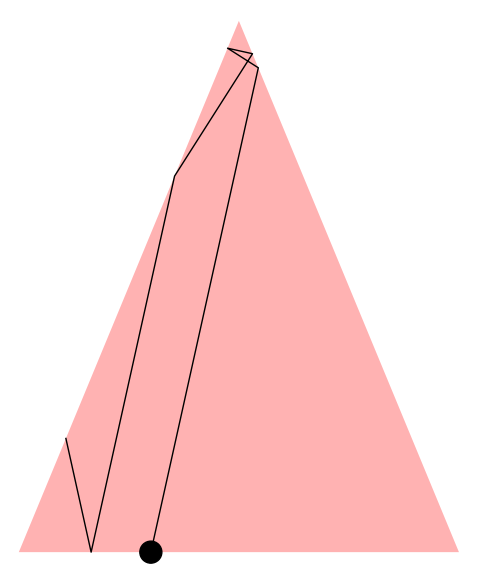

In [80]:
# first picture of the beamer
x = 0.3
d = Va((0.27324123005978,1.2314486735))
p = T.code_to_pos(0,x)
G = T.plot_orbit(0,x,d,iterations=6)
#(circle(p, 0.05, fill=True, color='black') + G).save('/tmp/billiard1.pdf', aspect_ratio=1, axes=False, figsize=3)
(circle(p, 0.05, fill=True, color='black') + G).show(aspect_ratio=1, axes=False)

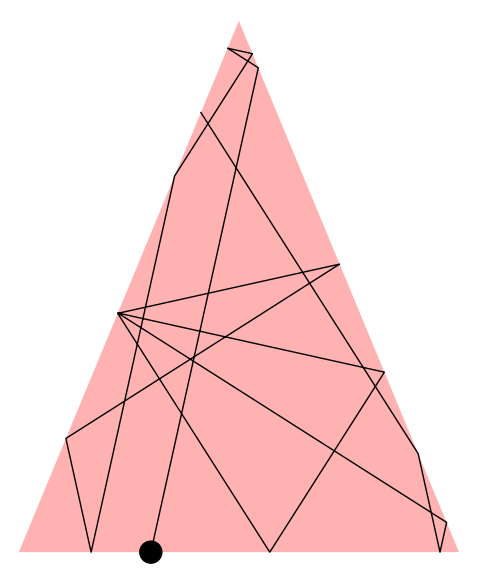

In [81]:
# the unfolded picture
x = 0.3
d = Va((0.27324123005978,1.2314486735))
p = T.code_to_pos(0,x)
G = T.plot_orbit(0,x,d,iterations=15)
#(circle(p, 0.05, fill=True, color='black') + G).save('/tmp/billiard2.pdf', aspect_ratio=1, axes=False, figsize=3)
(circle(p, 0.05, fill=True, color='black') + G).show(aspect_ratio=1, axes=False)

In [82]:
G2 = O.plot_orbit(0,0,x,d,iterations=15)
(circle(p, 0.05, fill=True, color='black') + G2).save('/tmp/billiard3.pdf', aspect_ratio=1, axes=False, figsize=3)

In [83]:
# compute a sequence of graphics to build a video
x = 0.3
d = Va((0.27324123005978,1.2314486735))
limits = [-sqrt2-.1, 2+sqrt2+.1, -.1, 2+2*sqrt2]
G = []
for n in range(30):
    G1 = O.plot_orbit(0,0,x,d,iterations=n)
    G1.axes(False)
    G1.set_axes_range(*limits)
    G2 = T.plot_orbit(0,x,d,iterations=n)
    G2.axes(False)
    G2.set_axes_range(*limits)
    G.append(graphics_array([G2,G1]))

In [84]:
# assembles the graphics in a video
A = animate(G)
A.ffmpeg('demo1.mp4', delay=40)

In [85]:
%%HTML
<video width="640" height="480" controls>
  <source src="demo1.mp4" type="video/mp4">
</video>

## Deviation of Birkhoff sums in the octagon

We consider the horizontal side in the octagon (the edge common to triangle 0 and 4 below). And compute how many intersections we have up to a given time (Birkhoff sums).

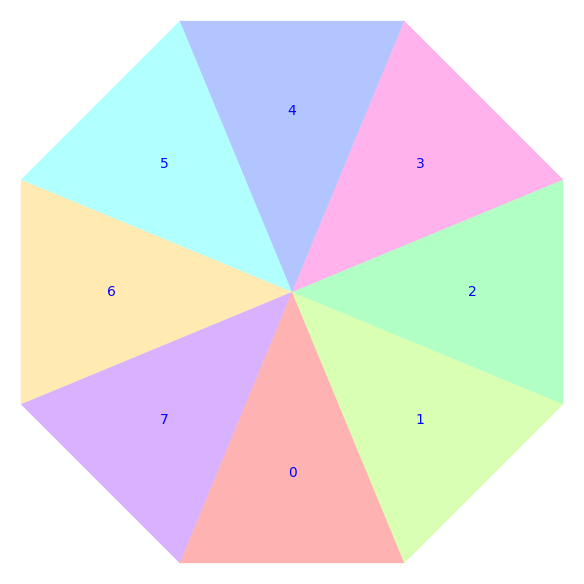

In [86]:
O.plot(labels=True).show(axes=False)

In [87]:
# total area of the octagon
area = 8 * O._triangles[0].area()
print area

19.313708499


In [88]:
def birkhoff_sums_octagon(x, d, num_intersection=1000):
    r"""
    Compute the number of intersections of the trajectory
    from ``x`` in the vertical direction ``d`` and the horizontal
    segment in the octagon.
    
    OUTPUT:
    
    A list of pairs `(length, intersection)`.
    """
    bs = [(0,0)]
    d /= d.norm()  # normalize the direction
    v = 0
    length = 0.0
    for i, sin, xin, sout, xout in O.orbit(0, 0, 0.11214, d, num_intersection):
        t = O._triangles[i]
        p0 = t.code_to_pos(sin, xin)
        p1 = t.code_to_pos(sout, xout)
        length += (p1 - p0).norm()
        if i == 0 and sin == 0:
            v += 1
            bs.append((length,v))
    return bs

Equidistribution (Kerckhoff-Masur-Smillie theorem): we print with the code below the number of intersections of a trajectory divided by the time versus the transversal measure of the side

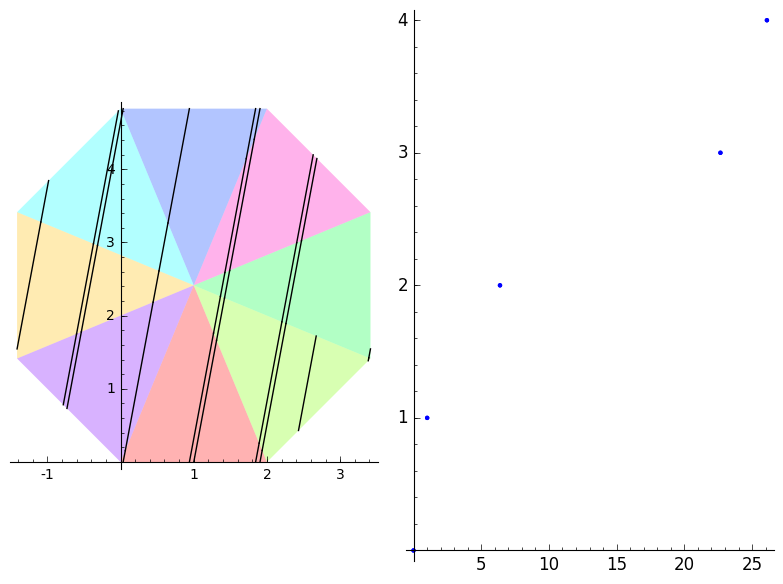

In [89]:
d = Va((0.12314311, 0.657123141))
x = 0.5
n = 35
bs = birkhoff_sums_octagon(x,d,n)
graphics_array([O.plot_orbit(0,0,x,d,iterations=n), point2d(bs)])

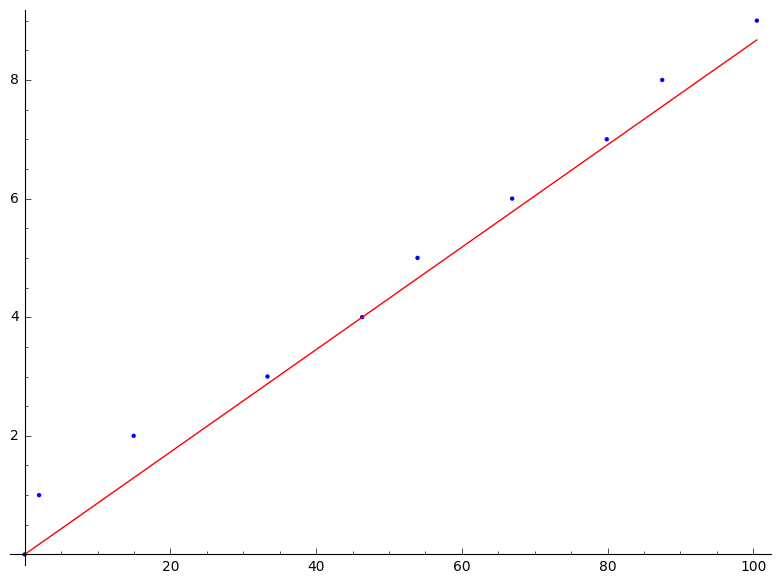

In [98]:
d = Va((0.471231120312, 0.711212768921))
d = d / d.norm()
bs = birkhoff_sums_octagon(0, d, 100)
l = bs[-1][0]
mean = d.dot_product(vector((0,2))) / area
point2d(bs) + line2d([(0,0), (l,mean*l)], color='red')

In [114]:
print "{:25} {:17} {:15}".format("direction", "empirical mean", "transversal measure")
for _ in range(10):
    d = (RDF**2).random_element(min=0,max=1) # random direction
    d /= d.norm()                            # normalize it
    x = RDF.random_element(0,1)              # initial point
    bs = birkhoff_sums_octagon(x, d)         # the number of intersections
    mean = d.dot_product(vector((0,2))) / area
    empirical = bs[-1][1] / bs[-1][0]
    print "{:25} {:17} {:15}".format(d.n(digits=4), empirical.n(digits=5), mean.n(digits=5))

direction                 empirical mean    transversal measure
(0.8033, 0.5955)          0.056278          0.061669       
(0.6575, 0.7534)          0.080703          0.078018       
(0.8602, 0.5100)          0.051629          0.052810       
(0.7882, 0.6155)          0.056878          0.063735       
(0.07193, 0.9974)         0.11069           0.10329        
(0.3802, 0.9249)          0.11372           0.095778       
(0.8467, 0.5321)          0.052366          0.055096       
(0.8180, 0.5752)          0.061633          0.059569       
(0.7301, 0.6833)          0.068280          0.070759       
(0.06648, 0.9978)         0.10504           0.10332        


In the cell below we compute and plot the renormalized Birkhoff sums $$i(S,\gamma,\theta,x,t) - t \mu_\theta(\gamma)$$ for $t$ in wider and wider ranges.

direction: (0.01320635534248983, 0.9999127922866913)   mean=0.103544359939


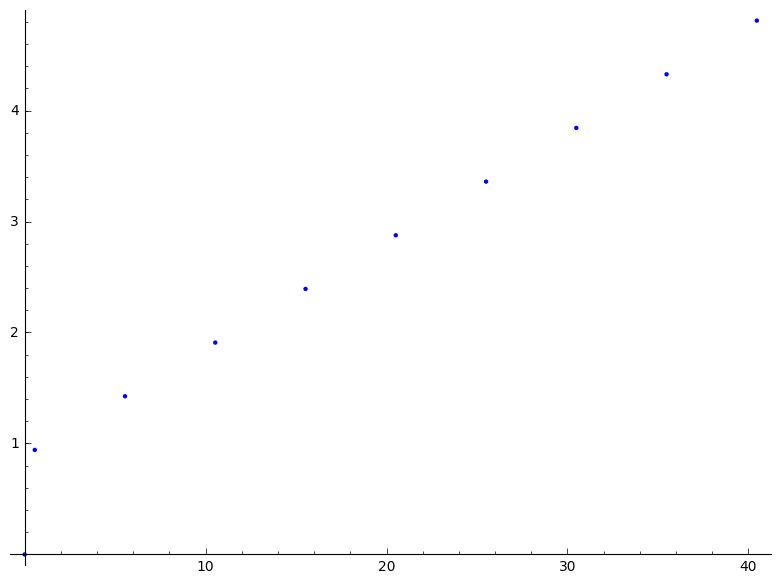

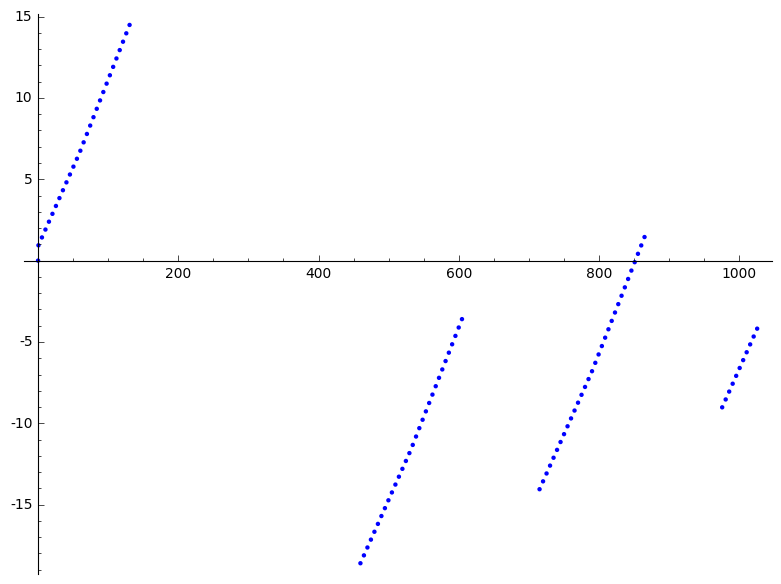

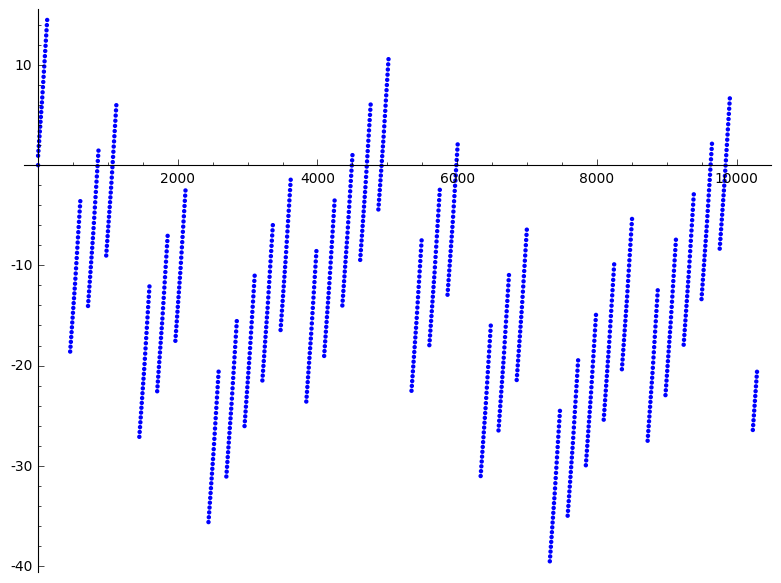

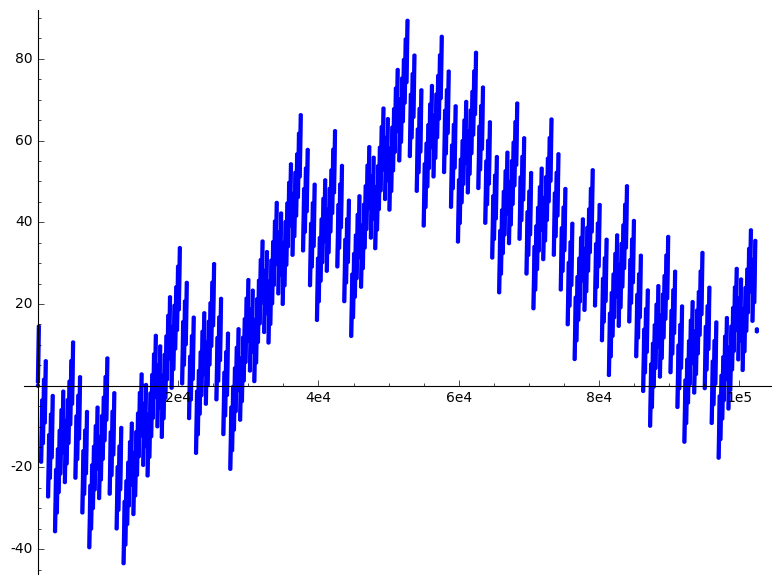

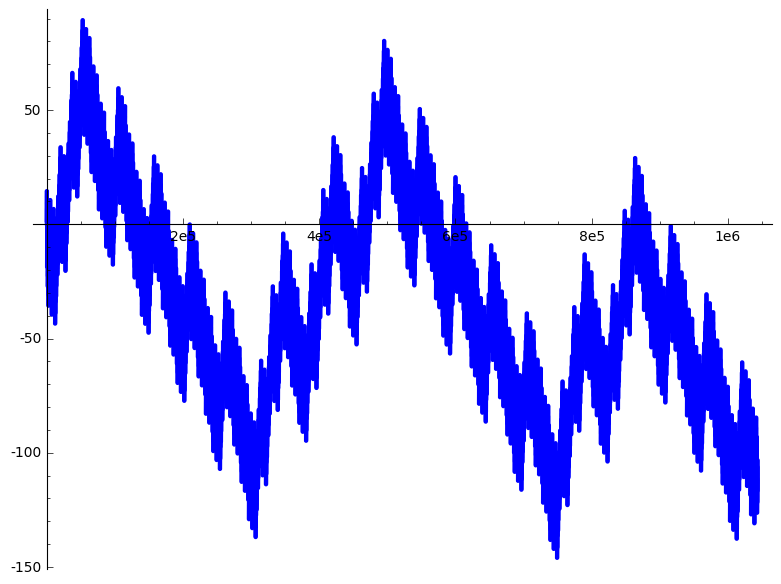

In [129]:
d = (RDF**2).random_element(min=0,max=1)    # random direction
d /= d.norm()                               # normalize it
mean = d.dot_product(vector((0,2))) / area  # transversal length
bs = birkhoff_sums_octagon(0.5, d, 10**6)   # Birkhoff sum
rbs = [(x, y - x*mean) for x,y in bs]       # renormalized Birkhoff sums
print "direction: {}   mean={}".format(d, mean)
for n in [(RR(len(rbs))**(k/5.)).floor() for k in range(1,6)]:
    point2d(rbs[:n]).show()

In [58]:
# to save the picture of the renormalized Birkhoff sum, just uncomment the line below
# point2d(rbs, pointsize=1).save('/tmp/birkhoff2.pdf', figsize=(4,2))

# Computing Lyapunov exponents using the surface dynamics package

This part needs the surface dynamics package to be installed. To that purpose, open a terminal and run the following command

    sage -pip install surface_dynamics

The code in this package was written mostly by me and the part about Lyapunov exponents by Charles Fougeron.

In [114]:
from surface_dynamics.all import *

In [121]:
# here is more or less the Lyapunov exponents associated to the octagon
# (exact values are 1, 1/3)
p = iet.Permutation('A B C D', 'B D A C')
p.stratum()

H_2(2)

In [117]:
p.lyapunov_exponents_H_plus()

[1.0055853164501598, 0.3296131518846267]

In [122]:
# and here the Lyapunov exponents associated to the windtree
# (exact values are 1, 2/3, 2/3, 1/3, 1/3)
S4 = SymmetricGroup(4)
i = S4('')
h = S4('(1,2)(3,4)')
v = S4('(1,3)(2,4)')
q = p.cover([i,h,v,i])

In [123]:
q.lyapunov_exponents_H_plus()

[1.0019240494550279,
 0.676566352078252,
 0.6656948165428316,
 0.35055284930066477,
 0.33435555212474305]